In [1]:
# You can run this code on Google Colab.
# Install conda
!pip install -q condacolab
import condacolab
condacolab.install()
# Install astra-toolbox
!conda install -c astra-toolbox astra-toolbox
# Install odl
!pip3 install https://github.com/odlgroup/odl/archive/master.zip

✨🍰✨ Everything looks OK!
Channels:
 - astra-toolbox
 - conda-forge
Platform: linux-64
Solving environment: / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

  Using cached https://github.com/odlgroup/odl/archive/master.zip
  Preparing metadata (setup.py) ... done


ASTRA Toolbox v2.1.3
Getting GPU info... GPU #0: Tesla T4, with 15102MB, CUDA compute capability 7.5
Testing basic CPU 2D functionality... Ok
Testing basic CUDA 2D functionality... Ok
Testing basic CUDA 3D functionality... Ok
sinogram size = (30, 365)


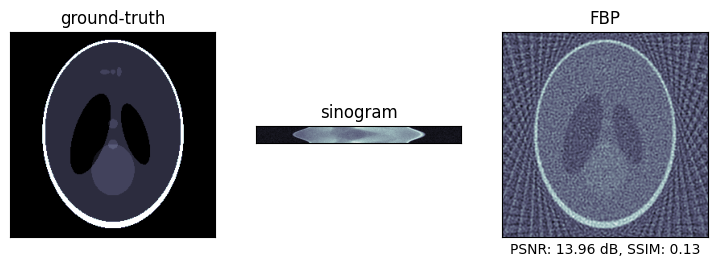

In [2]:
# import libraries for CT and deep learning
import odl
import numpy as np
import matplotlib.pyplot as plt
import astra
astra.test()
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim


import torch
import odl
import odl.contrib.torch as odl_torch
# --- Set up the forward operator (ray transform) in ODL --- #
# Reconstruction space: functions on the rectangle [-20, 20]^2
img_size = 256 # discretized with 256 samples per dimension
reco_space = odl.uniform_discr(min_pt=[-20, -20], max_pt=[20, 20],
                               shape=[img_size, img_size], dtype='float32')

# Make a parallel beam geometry with flat detector, using number of angles = num_angles
num_angles = 30
geometry = odl.tomo.parallel_beam_geometry(reco_space, num_angles=num_angles)

# Create the forward operator, adjoint operator, and the FBO operator in ODL
fwd_op_odl = odl.tomo.RayTransform(reco_space, geometry)
fbp_op_odl = odl.tomo.fbp_op(fwd_op_odl,filter_type='Ram-Lak',
                             frequency_scaling=0.6)
adj_op_odl = fwd_op_odl.adjoint


# Create phantom and noisy projection data in ODL
phantom_odl = odl.phantom.shepp_logan(reco_space, modified=True)
data_odl = fwd_op_odl(phantom_odl)
data_odl += odl.phantom.white_noise(fwd_op_odl.range) * np.mean(data_odl) * 0.1
fbp_odl = fbp_op_odl(data_odl)

# convert the image and the sinogram to numpy arrays
phantom_np = phantom_odl.__array__()
fbp_np = fbp_odl.__array__()
data_np = data_odl.__array__()
print('sinogram size = {}'.format(data_np.shape))

### display ground-truth and FBP images
plt.subplot(131)
plt.imshow(phantom_np.transpose(),cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title('ground-truth')

plt.subplot(132)
plt.imshow(data_np,cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title('sinogram')

plt.subplot(133)
plt.imshow(fbp_np.transpose(),cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title('FBP')
data_range=np.max(phantom_np)-np.min(phantom_np)
psnr_fbp = compare_psnr(phantom_np,fbp_np,data_range=data_range)
ssim_fbp = compare_ssim(phantom_np,fbp_np,data_range=data_range)
plt.xlabel('PSNR: {:.2f} dB, SSIM: {:.2f}'.format(psnr_fbp, ssim_fbp))
plt.gcf().set_size_inches(9.0,6.0)

In [3]:
print(phantom_np.shape)
print(data_np.shape)
print(fbp_np.shape)

(256, 256)
(30, 365)
(256, 256)


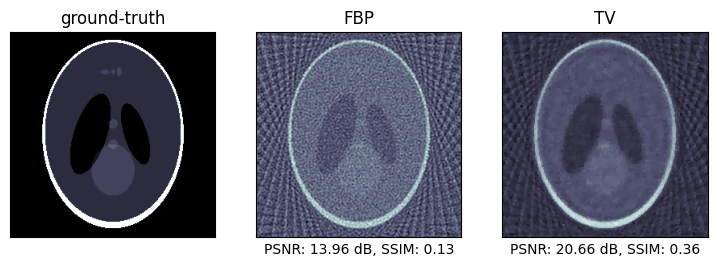

In [4]:
# Let's solve the TV reconstruction problem using the linearized ADMM algorithm (implemented in ODL).

# In this example we solve the optimization problem: min_x  f(x) + g(Lx) = ||A(x) - y||_2^2 + lam * ||grad(x)||_1, Where ``A`` is a parallel beam ray transform, ``grad`` is the spatial gradient and ``y`` given noisy data.

# The problem is rewritten in decoupled form as: min_x g(L(x)) with a separable sum ``g`` of functionals and the stacked operator ``L``:

#     g(z) = ||z_1 - g||_2^2 + lam * ||z_2||_1,

#                ( A(x)    )
#     z = L(x) = ( grad(x) ).

# Gradient operator for the TV part
grad = odl.Gradient(reco_space)

# Stacking of the two operators
L = odl.BroadcastOperator(fwd_op_odl, grad)

# Data matching and regularization functionals
data_fit = odl.solvers.L2NormSquared(fwd_op_odl.range).translated(data_odl)
lam = 0.015
reg_func = lam * odl.solvers.L1Norm(grad.range)
g = odl.solvers.SeparableSum(data_fit, reg_func)

# We don't use the f functional, setting it to zero
f = odl.solvers.ZeroFunctional(L.domain)

# --- Select parameters and solve using ADMM --- #

# Estimated operator norm, add 10 percent for some safety margin
op_norm = 1.1 * odl.power_method_opnorm(L, maxiter=20)

niter = 200  # Number of iterations
sigma = 2.0  # Step size for g.proximal
tau = sigma / op_norm ** 2  # Step size for f.proximal

# Optionally pass a callback to the solver to display intermediate results
callback = (odl.solvers.CallbackPrintIteration(step=10) &
            odl.solvers.CallbackShow(step=10))

# Choose a starting point
x_admm_odl = L.domain.zero()

# Run the algorithm
odl.solvers.admm_linearized(x_admm_odl, f, g, L, tau, sigma,
                            niter, callback=None)
x_admm_np = x_admm_odl.__array__()

# Let's display the image reconstructed by ADMM and compare it with FBP
plt.subplot(131)
plt.imshow(phantom_np.transpose(),cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title('ground-truth')

plt.subplot(132)
plt.imshow(fbp_np.transpose(),cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title('FBP')
plt.xlabel('PSNR: {:.2f} dB, SSIM: {:.2f}'.format(psnr_fbp, ssim_fbp))


plt.subplot(133)
plt.imshow(x_admm_np.transpose(),cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title('TV')
psnr_tv = compare_psnr(phantom_np,x_admm_np,data_range=data_range)
ssim_tv = compare_ssim(phantom_np,x_admm_np,data_range=data_range)
plt.xlabel('PSNR: {:.2f} dB, SSIM: {:.2f}'.format(psnr_tv, ssim_tv))
plt.gcf().set_size_inches(9.0,6.0)

In [5]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# Now, we need to cast the ODL operators as torch operators so that we can integrate them with other learnable units. For brevity, we will omit the suffix _torch in the variable and operator names.
fwd_op = odl_torch.OperatorModule(fwd_op_odl).to(device)
adj_op = odl_torch.OperatorModule(fwd_op_odl.adjoint).to(device)
fbp_op = odl_torch.OperatorModule(fbp_op_odl).to(device)

Device: cuda


In [ ]:
# Now, we will "train" learned gradient descent (LGD) network on this specific image to show the potential of data-driven reconstruction.
# Keep in mind that this example is unrealistic, in the sense that in practice you will train your learned reconstruction network on a dataset containing
# many images, and then test the performance on a new test image (that was not a part of your training dataset).

import torch.nn as nn

### first, let's create a CNN that replaces the prox operator in PGD.
class prox_net(nn.Module):
    def __init__(self, n_in_channels=2, n_out_channels = 1, n_filters=32, kernel_size=3):
        super(prox_net, self).__init__()
        self.pad = (kernel_size-1)//2
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)

        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)

    def forward(self, x, u):
        ''' ################## YOUR CODE HERE #################### '''
        ### Note: here the two inputs denote the current iterate and the gradient
        dx = torch.cat((x,u),dim=0)
        dx = self.act1(self.conv1(input))
        dx = self.act2(self.conv2(dx))
        dx = self.conv3(dx)

        return dx

# Let's compute a reasonable initial value for the step-size as step_size = 1/L, where L is the spectral norm of the forward operator.
op_norm = 1.1*odl.power_method_opnorm(fwd_op_odl)
step_size = 1/op_norm

class LGD_net(nn.Module):
    def __init__(self, niter=5,step_size=step_size):
        super(LGD_net, self).__init__()
        self.niter = niter
        self.prox = nn.ModuleList([prox_net().to(device) for i in range(self.niter)])
        self.step_size = nn.Parameter(step_size * torch.ones(self.niter).to(device))
    def forward(self, y, x_init):
        x = x_init
        ''' ################## YOUR CODE HERE #################### '''
        #### Note: the gradient at a given x is A^T(Ax-y).
        for k in range(self.niter):
            grad = adj_op(fwd_op(x)-y)
            dx = self.prox[k](x,grad)
            x = x - self.step_size[k] * dx
        return x


lgd_net = LGD_net().to(device) # realize the network and export it to GPU
num_learnable_params = sum(p.numel() for p in lgd_net.parameters() if p.requires_grad)
print('number of model parameters = {}'.format(num_learnable_params))
y = torch.from_numpy(data_np).to(device).unsqueeze(0) # noisy sinogram data as a torch tensor

# initialization for the LGD net. Note that the input to a torch 2D CNN must be of size (num_batches x height x width).
x_init = fbp_op(y)

ground_truth = torch.from_numpy(phantom_np).to(device).unsqueeze(0) # target ground-truth as a torch tensor

# define the loss and the optimizer
mse_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lgd_net.parameters(),lr = 1e-4)
num_epochs = 2000

##### training loop
for epoch in range(0, num_epochs):
    print('epoch = {}'.format(epoch))
    optimizer.zero_grad()
    '''################## YOUR CODE HERE #################### '''
    #### You need to compute the reconstructed image by applying a forward pass through lgd_net, compute the loss, call the backward function on loss, and update the parameters.
    recon = lgd_net(y, x_init)
    loss = mse_loss(recon, ground_truth)
    loss.backward()
    optimizer.step()

    if(epoch%100 == 0):
        print('epoch = {}, loss = {}'.format(epoch, loss.item()))

lgd_recon_np = recon.detach().cpu().numpy().squeeze() # convert the LGD reconstruction to numpy format
###############################################
# Let's display the reconstructed images by LGD and compare it with FBP and ADMM
plt.subplot(141)
plt.imshow(phantom_np.transpose(),cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title('ground-truth')

plt.subplot(142)
plt.imshow(fbp_np.transpose(),cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title('FBP')
plt.xlabel('PSNR: {:.2f} dB, SSIM: {:.2f}'.format(psnr_fbp, ssim_fbp))


plt.subplot(143)
plt.imshow(x_admm_np.transpose(),cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title('TV')
plt.xlabel('PSNR: {:.2f} dB, SSIM: {:.2f}'.format(psnr_tv, ssim_tv))
plt.gcf().set_size_inches(9.0,6.0)


plt.subplot(144)
plt.imshow(lgd_recon_np.transpose(),cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title('LGD')
psnr_lgd = compare_psnr(phantom_np,lgd_recon_np,data_range=data_range)
ssim_lgd = compare_ssim(phantom_np,lgd_recon_np,data_range=data_range)
plt.xlabel('PSNR: {:.2f} dB, SSIM: {:.2f}'.format(psnr_lgd, ssim_lgd))
plt.gcf().set_size_inches(12.0,6.0)

number of model parameters = 50740
epoch = 0
epoch = 0, loss = 0.03885279595851898
epoch = 1
epoch = 2
epoch = 3
epoch = 4
epoch = 5
epoch = 6
epoch = 7
epoch = 8
epoch = 9
epoch = 10
epoch = 11
epoch = 12
epoch = 13
epoch = 14
epoch = 15
epoch = 16
epoch = 17
epoch = 18
epoch = 19
epoch = 20
epoch = 21
epoch = 22
epoch = 23
epoch = 24
epoch = 25
epoch = 26
epoch = 27
epoch = 28
epoch = 29
epoch = 30
epoch = 31
epoch = 32
epoch = 33
epoch = 34
epoch = 35
epoch = 36
epoch = 37
epoch = 38
epoch = 39
epoch = 40
epoch = 41
epoch = 42
epoch = 43
epoch = 44
epoch = 45
epoch = 46
epoch = 47
epoch = 48
epoch = 49
epoch = 50
epoch = 51
epoch = 52
epoch = 53
epoch = 54
epoch = 55
epoch = 56
epoch = 57
epoch = 58
epoch = 59
epoch = 60
epoch = 61
epoch = 62
epoch = 63
epoch = 64
epoch = 65
epoch = 66
epoch = 67
epoch = 68
epoch = 69
epoch = 70
epoch = 71
epoch = 72
epoch = 73
epoch = 74
epoch = 75
epoch = 76
epoch = 77
epoch = 78
epoch = 79
epoch = 80
epoch = 81
epoch = 82
epoch = 83
epoch = 84
ep